Utilizzo di pynetlogo per una singola simulazione.

È una pessima idea lanciare run all.

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import os

%matplotlib widget

### Impostazioni

In [2]:
outputdir = os.path.join('.','outputs','update2') # directory dove salvare config e output
if not os.path.exists(outputdir):
  os.makedirs(outputdir)
nl_gui = True           # false per non far partire la gui di netlogo
nl_model = "./EC2.8.nlogo" # modello da caricare in netlogo

Runnare una delle due celle seguenti in base a se vuoi cambiare variabili o caricarle da un file

In [3]:
# CARICAMENTO VARIABILI DA FILE
with open(outputdir+"/global_vars.json",'r') as f:
  global_vars = json.load(f)

print(global_vars)

{'N': 1000, 'beta': 1.0, 'mutrue': 0.0, 'vartrue': 1.0, 'update-type': 2, 'var-c': 10.0, 'var-d': 2, 'network-type': '"scale-free"', 'p': 0.01, 'pref': 1}


### Simulazione singola

#### Caricamento netlogo

In [4]:
## perché funzioni: installato tutto da conda tranne pynetlogo, installato per ultimo
## java-21-openjdk
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

In [5]:
netlogo.load_model(nl_model)

In [6]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [7]:
netlogo.report(f"count nodes")

0.0

#### Avvio simulazione

In [9]:
# IMPOSTAZIONE VARIABILI GLOBALI DA PYTHON e salvataggio nel file
global_vars = {
  'N': 1000,
  'beta': 1.,
  'mutrue': 0.,
  'vartrue': 1.,
  'update-type': 2,
  'var-c': 10.,
  'var-d': 2,
  'network-type': "\"scale-free\"", #random o scale-free
  'p': 0.01, # random network, probabilità di accendere link
  'pref': 1
}

# with open(os.path.join(outputdir,"global_vars.json"),'w') as f:
#   f.write(json.dumps(global_vars,indent=2))

In [179]:
# IMPOSTAZIONE VARIABILI GLOBALI E SETUP IN NETLOGO
netlogo.command('clear-all')
for name in global_vars:
  netlogo.command(f'set {name} {global_vars[name]}')

netlogo.command('setup')

In [180]:
iters = 100
mus = []
sigma2s = []
nets = []
lones = []
rewired =[]
mus.append(values('mu0'))
sigma2s.append(values('var0'))
nets.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int))

In [ ]:
for n in range(1,iters+1):
  netlogo.command('go')
  mus.append(values('mu'))
  sigma2s.append(values('var'))
  lones.append(netlogo.report('lonely'))
  rewired.append(netlogo.report('rewired'))
  if (n%10)==0:
    nets.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int))
  print(f"\r{n}/{iters}",end="",flush=True)
print()

100/100


In [186]:
np.unique(nets[99],axis=0)

array([[  0,   1],
       [  0,   2],
       [  1,   2],
       ...,
       [998, 800],
       [999,  20],
       [999, 407]], shape=(1997, 2))

In [29]:
np.unique(np.array([[1,2],[2,1],[1,2]]),axis=0)

array([[1, 2],
       [2, 1]])

#### Salvataggio

In [49]:
import datetime
datestr = datetime.datetime.now().strftime("%m_%d_%H_%M")
outputsubdir=os.path.join(outputdir,
                     f'beta={global_vars['beta']:.1f}_varc={global_vars['var-c']:.1f}',
                     datestr)
print(outputsubdir)

./outputs/update2/beta=1.0_varc=10.0/07_13_12_06


In [14]:
os.makedirs(outputsubdir)
np.save(os.path.join(outputsubdir,'mus.npy'),
        mus)
np.save(os.path.join(outputsubdir,"sigma2s.npy"),
        sigma2s)
np.save(os.path.join(outputsubdir,"nets.npy"),
        nets)

#### Qualche plot dei risultati

In [50]:
meanmu = np.array([np.mean(mu) for mu in mus])
meansigma = np.sqrt(np.array([np.mean(var) for var in sigma2s]) )

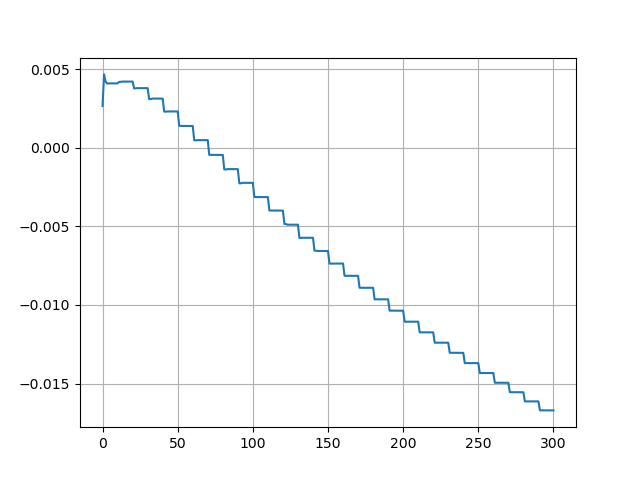

In [51]:
plt.close('all')
plt.plot(meanmu)
plt.grid()

In [17]:
muarr = np.array(mus)
muarr.shape

(301, 1000)

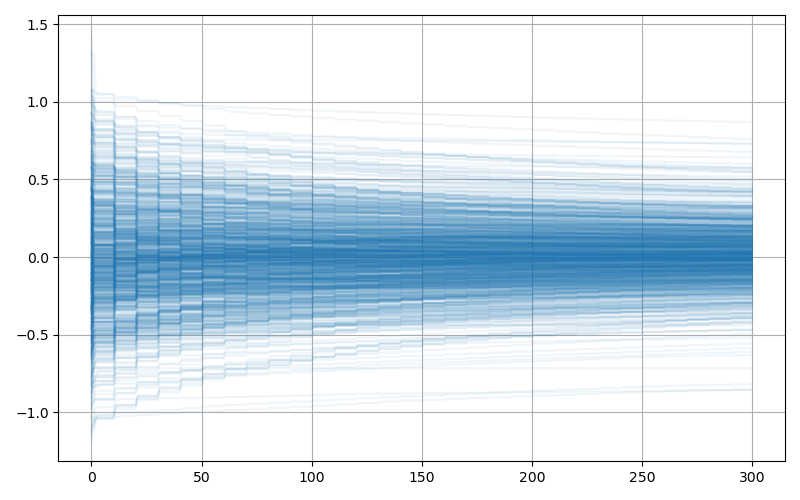

In [19]:
fig, ax = plt.subplots(figsize = (8,5), layout='tight')
for i in range(1000):
  #ax.plot(mus[i],alpha=0.05,color='C0')
  ax.plot(np.array(mus)[:,i],alpha=0.07, color='C0')

#ax.plot( np.array(mus)[:,0] )

ax.grid()

In [20]:
mu = mus[-1]#values('mu')
sigmas = np.sqrt(sigma2s[-1])#np.sqrt(values('var'))

In [21]:
# vettore del numero di nodi concordi, per ciascun nodo
friends = [np.sum([(abs(m - mu[i])< global_vars['beta']* sigmas[i]) for m in (mu)]) for i in range(1000)]

In [23]:
np.min(friends), np.max(friends),lones[-1]

(np.int64(1), np.int64(1000), 2.0)

In [24]:
bff = np.argmax(friends) # nodo con più amici tra tutti
wff = np.argmin(friends) 
bff,wff

(np.int64(2), np.int64(792))

In [25]:
netlogo.report(f'[mu] of node {bff}'),netlogo.report(f'[var] of node {bff}')

(0.010263979221830376, 1.6467780107080732)

In [19]:
for i in range(25,31):
  print(np.unique(nets[i],axis=0).shape,nets[i].shape)

(1995, 2) (1997, 2)
(1993, 2) (1997, 2)
(1993, 2) (1997, 2)
(1996, 2) (1997, 2)
(1996, 2) (1997, 2)
(1993, 2) (1997, 2)


In [53]:
unique,count=np.unique(nets[1],axis=0,return_counts=True)


In [54]:
np.arange(1995)[count==2]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1995 but size of corresponding boolean axis is 1997

In [55]:
unique[1021]

array([324,  13])

In [62]:
nets[1][nets[1][:,0]==nets[1][:,1]]

array([], shape=(0, 2), dtype=int64)

In [27]:
netlogo.report(f'[mu] of node {wff}'),netlogo.report(f'[var] of node {wff}')

(1.098641130409696, 0.06408035060867036)

Text(0.5, 1.0, 'Distribuzione numero di nodi concordi per ciascun nodo')

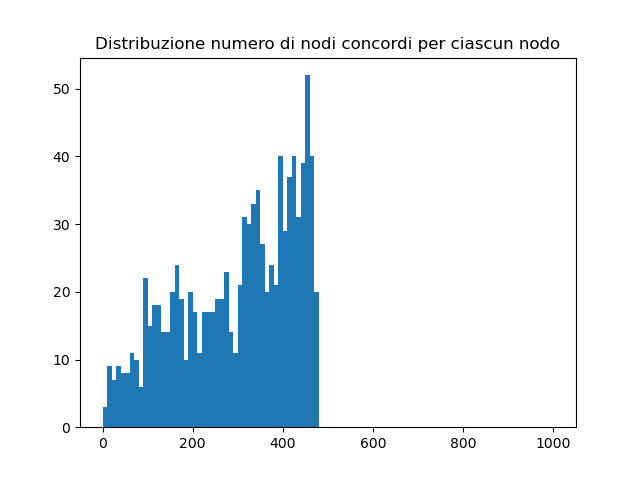

In [33]:
plt.close('all')
plt.hist(friends,bins=100,range=(0,1000))
plt.title('Distribuzione numero di nodi concordi per ciascun nodo')

In [34]:
netlogo.report('[tc] of edges').sum()

np.float64(4.0)

In [38]:
lones[-1],netlogo.report('pref')

(4.0, 1.0)

In [56]:
[len(np.unique(net,axis=0)) for net in nets]

[1997,
 1997,
 1997,
 1997,
 1997,
 1997,
 1997,
 1997,
 1997,
 1997,
 1996,
 1997,
 1996,
 1996,
 1996,
 1996,
 1997,
 1997,
 1997,
 1997,
 1997,
 1996,
 1995,
 1995,
 1995,
 1994,
 1995,
 1997,
 1996,
 1996,
 1996]

In [57]:
netlogo.command("show \"cia\"")

observer: "cia"


In [ ]:
net

In [55]:
un, count = np.unique(nets[-1],axis=0,return_counts=True)
un[count.argmax()]

array([ 14, 438])

In [65]:
values('count my-out-edges')

array([2., 1., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [32]:
values('count nodes with [(self != myself) and (in-edge-from myself = nobody) and (not banned?) and (abs(mu0 - [mu0] of myself) < (beta * [sqrt(var0)] of myself))]')

array([915., 948., 999., 774., 922., 588., 613., 812., 937., 939., 840.,
       787., 929., 912., 924., 877., 755., 940., 894., 867., 798., 898.,
       897., 905., 853., 448., 936., 159., 901., 470., 921., 792., 699.,
       924., 920., 925., 857., 936., 831., 898., 880., 890., 904., 913.,
       893., 930., 933., 892., 926., 604., 863., 788., 893., 913., 769.,
       935., 529., 827., 902., 168., 924., 776., 926., 898., 772., 917.,
       931., 420., 743.,  19., 777., 883., 920., 838., 915., 935., 904.,
       691., 908., 920., 439., 832., 814., 913., 915., 886., 896., 854.,
       895., 937., 930., 926., 766., 929., 696., 906., 929., 916., 880.,
       854., 915., 920., 794., 888., 927., 930., 928., 850., 915., 795.,
       644., 854., 858., 704., 743., 932., 754., 905., 894., 916., 917.,
       863., 874., 934., 846., 904., 912., 900., 196., 567., 799., 925.,
       929., 910., 926., 858., 828., 939., 907., 920., 878., 763., 874.,
       919., 895., 413., 938., 864., 844., 922., 92

In [34]:
values('count nodes with [(self != myself) and (in-edge-from myself = nobody)]')

array([997., 998., 999., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 997., 997., 997., 997.,
       997., 997., 997., 997., 997., 997., 997., 99

In [13]:
G0  = nx.from_edgelist(nets[0].tolist(),create_using=nx.DiGraph)
GF = nx.from_edgelist(nets[-1].tolist(),create_using=nx.DiGraph)

In [14]:
G0.out_edges(0)

OutEdgeDataView([(0, 835), (0, 21), (0, 116), (0, 28), (0, 581), (0, 82), (0, 51), (0, 284), (0, 4), (0, 7), (0, 2), (0, 225), (0, 291), (0, 43), (0, 1), (0, 71), (0, 472), (0, 477), (0, 68), (0, 614), (0, 391), (0, 5)])

In [46]:
sorted([len(i) for i in nx.strongly_connected_components(G0)],reverse=True)[:10],sorted([len(i) for i in nx.strongly_connected_components(GF)],reverse=True)[:10]

([535, 1, 1, 1, 1, 1, 1, 1, 1, 1], [663, 4, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
netlogo.report('count edges')

1997.0

In [48]:
len(GF.edges),len(G0.edges)

(1994, 1997)

In [ ]:
for i in nets:
  print(len(i))

1997
2001
2001
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2003
2003
2003
2004
2004
2004
2004
2004
2004
2004
2004


: 

In [18]:
len(np.unique(nets[-1],axis=0))

1993

In [149]:
np.unique([[1,2],[1,2],[2,1],[3,4]])

array([1, 2, 3, 4])

In [123]:
nets[0][~np.unique(nets[0])]

array([[  6,  12],
       [458, 207],
       [984, 446],
       ...,
       [ 56,   6],
       [676,  47],
       [ 13, 289]], shape=(1000, 2))

In [125]:
nets[0][np.unique(nets[0])]

array([[928,  12],
       [136, 356],
       [  6, 281],
       ...,
       [ 13, 289],
       [676,  47],
       [ 56,   6]], shape=(1000, 2))

In [118]:
998*2+1

1997

(array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,
         3.,  3.,  1.,  6.,  2.,  1.,  2.,  2.,  7.,  4.,  2.,  4., 11.,
         4.,  4.,  6.,  9.,  8.,  5., 14., 11.,  8., 17., 23., 22., 10.,
        26., 20., 21., 31., 20., 23., 18., 24., 22., 30., 23., 31., 17.,
        22., 20., 22., 28., 29., 23., 26., 22., 28., 24., 14., 16., 27.,
        15., 18., 17., 16.,  9.,  8., 10., 10.,  8., 10.,  6.,  6.,  8.,
         4.,  3.,  4.,  5.,  5.,  6.,  4.,  6.,  3.,  5.,  2.,  2.,  1.,
         2.,  0.,  2.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([-1.42264511, -1.39553707, -1.36842903, -1.34132098, -1.31421294,
        -1.2871049 , -1.25999686, -1.23288882, -1.20578078, -1.17867274,
        -1.1515647 , -1.12445665, -1.09734861, -1.07024057, -1.04313253,
        -1.01602449, -0.98891645, -0.96180841, -0.93470036, -0.90759232,
        -0.88048428, -0.85337624, -0.8262682 , -0.79916016, -0.77205212,
        -0.74494407, -0.71783603, -0.69072799, -0.66361995, -0.636511

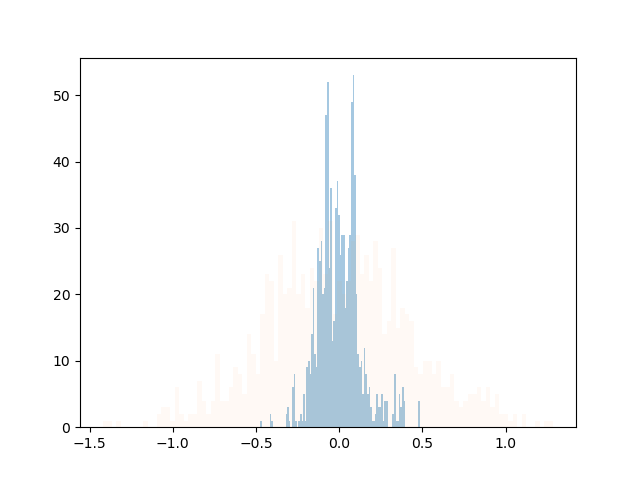

In [31]:
plt.close('all')
plt.hist(mus[-1],bins=100,alpha=0.4)
plt.hist(mus[0],bins=100,alpha=0.04)

In [32]:
np.min(mus[-1])

np.float64(-0.4755753419796451)

#### Salvataggio medie, varianze e grafo
metto una stringa con data e ora prima per identificare le simulazioni; la cartella definita sopra identifica il setup.

`*outputdir*/MESE_GIORNO_ORE_MINUTI_mus.npy`

si riaprono con `np.load(*path*)`

Per salvare il grafo, la roba più easy mi sembra salvare la edgelist in un file csv; ogni riga è un link, tipo:
```
0,1
1,0
0,2
2,0
```
eccetra; si può caricare in networkx con `graph = nx.read_edgelist(*filepath*, delimiter=',',nodetype=int)`.

In [ ]:
## both-ends non tiene conto della direzione del link!!!
netlogo.command( f"csv:to-file \"{outputdir}{datestr}_edgelist.csv\" [ [ (who) ] of both-ends ] of links" )

NameError: name 'datestr' is not defined

In [169]:
netlogo.report('[label] of node 100')

100.0

Per averla in python direttamente:

In [177]:
edgelist=netlogo.report("[list ([label] of end1) ([label] of end2)] of edges")

In [178]:
np.unique(edgelist,axis=0)

array([[  0.,   1.],
       [  0.,   2.],
       [  1.,   2.],
       ...,
       [998., 535.],
       [999.,  22.],
       [999., 501.]], shape=(1997, 2))

In [ ]:
import networkx as nx

In [24]:
G  = nx.from_edgelist(edgelist.tolist(),create_using=nx.DiGraph)

In [28]:
G.in_edges(1)

InEdgeDataView([(572, 1), (190, 1), (40, 1), (443, 1), (76, 1), (539, 1), (859, 1), (876, 1), (13, 1), (446, 1), (502, 1), (923, 1), (197, 1), (912, 1), (302, 1), (506, 1), (702, 1), (872, 1), (42, 1), (783, 1), (90, 1)])

In [25]:
sorted([len(i) for i in nx.strongly_connected_components(G)],reverse=True)

[596,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1

In [ ]:
netlogo.kill_workspace()

### Simulazioni multiple

In [ ]:
num_sim = 10 #numero di simulazioni da effettuare
iters = 100  #iterazioni per ogni simulazione

muzeros = [] # liste che conterranno tutte le mu di tutte le simulazioni
sigma2zeros = []
mufinals = []
sigma2finals = []
edgelists = []

In [ ]:
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

netlogo.load_model(nl_model)

NetLogo Startup Error
org.picocontainer.PicoCompositionException: Duplicate Keys not allowed. Duplicate for 'class org.nlogo.compile.Compiler'
	at org.picocontainer.DefaultPicoContainer.addAdapterInternal(DefaultPicoContainer.java:438)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:548)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:501)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:488)
	at org.nlogo.util.Pico.add(Pico.scala:11)
	at org.nlogo.app.App$.mainWithAppHandler(App.scala:86)
	at org.nlogo.app.App$.main(App.scala:68)
	at org.nlogo.app.App.main(App.scala)
	at netLogoLink.NetLogoLink.<init>(NetLogoLink.java:44)


: 

In [53]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [ ]:
for sim in range(num_sim):
  netlogo.command('clear-all')
  for name in global_vars:
    netlogo.command(f'set {name} {global_vars[name]}')

  netlogo.command('setup')

  muzeros.append(values('mu0'))
  sigma2zeros.append(values('var0'))
  edgelists.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int) )

  for n in range(1,iters+1):
    netlogo.command('go')
    #mus.append(values('mu'))
    #sigma2s.append(values('var'))
    print(f"\rSimulazione {sim}, timestep {n}/{iters}",end="",flush=True)
  print()
  mufinals.append(values('mu'))
  sigma2finals.append(values('var'))

Simulazione 0, timestep 100/100
Simulazione 1, timestep 100/100
Simulazione 2, timestep 100/100
Simulazione 3, timestep 100/100
Simulazione 4, timestep 100/100
Simulazione 5, timestep 100/100
Simulazione 6, timestep 100/100
Simulazione 7, timestep 100/100
Simulazione 8, timestep 100/100
Simulazione 9, timestep 100/100


In [76]:
netlogo.kill_workspace()

In [83]:
amus = np.array(mufinals)
asigma2s = np.array(sigma2finals)

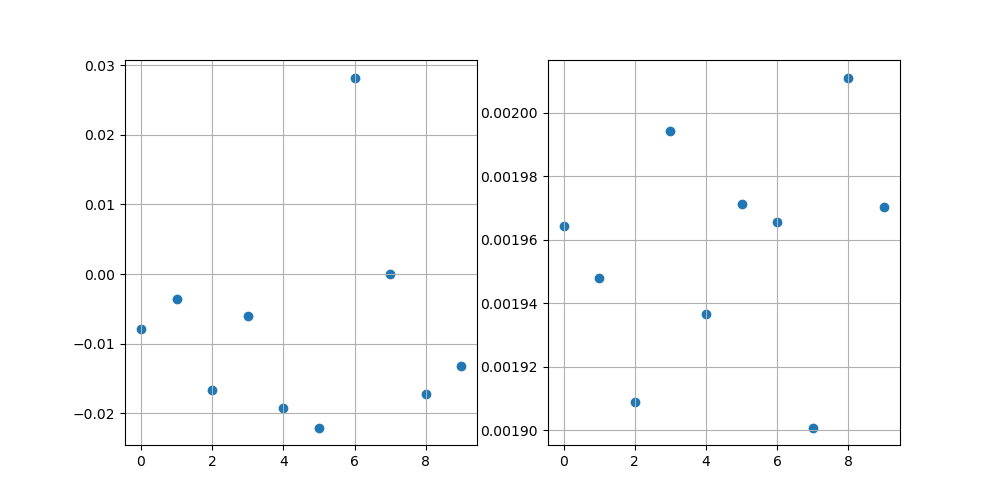

In [87]:
fig, ax = plt.subplots(ncols=2, figsize =(10,5))
ax[0].scatter(np.arange(10),np.mean(amus,axis=1))
ax[1].scatter(np.arange(10),np.mean(asigma2s,axis=1))


for a in ax:
  a.grid()

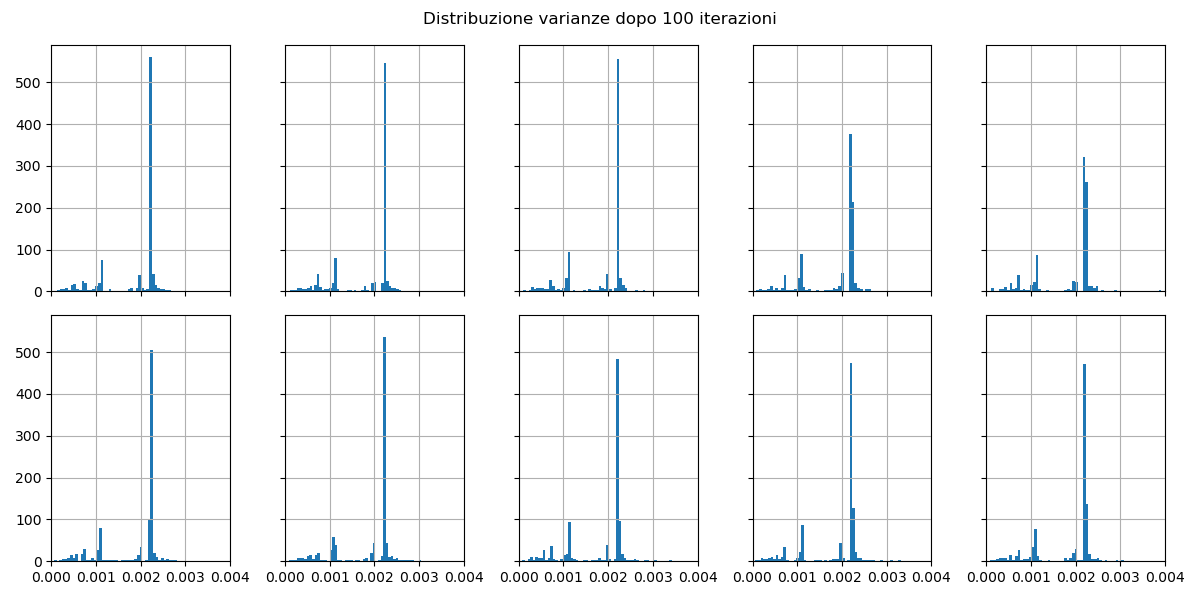

In [115]:
fig1,ax1 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all', sharex='all',layout='tight')
fig1.suptitle('Distribuzione varianze dopo 100 iterazioni')
for i,a in enumerate(ax1.flatten()):
  a.hist(asigma2s[i],bins=300)
  a.set_xlim((0,0.004))
  a.grid()

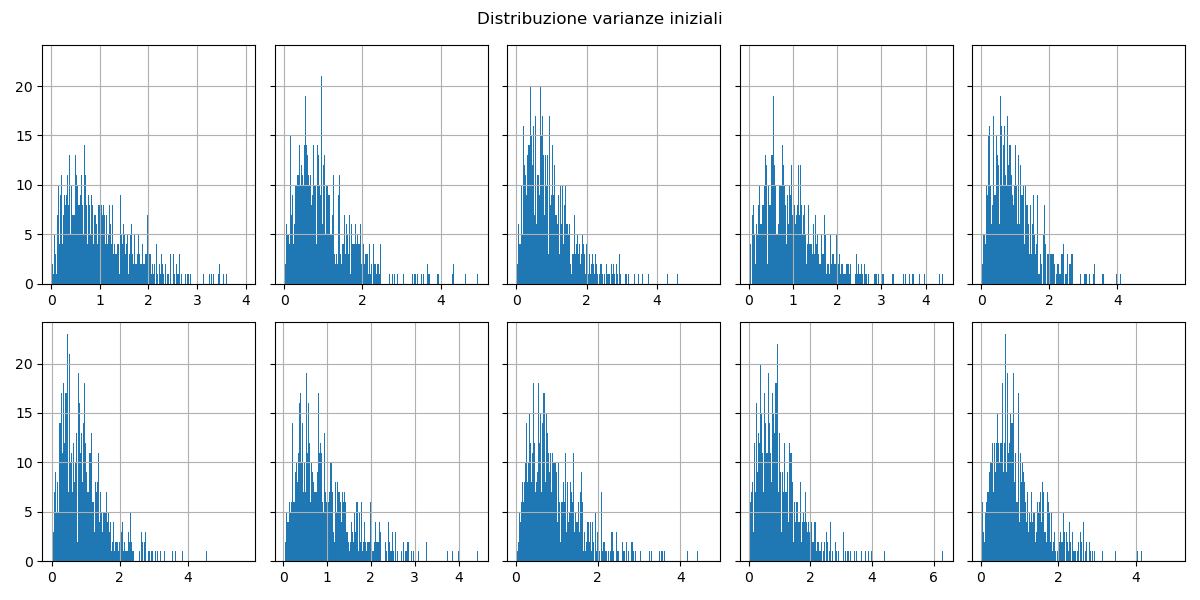

In [116]:
fig2,ax2 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',layout='tight')
fig2.suptitle('Distribuzione varianze iniziali')
for i,a in enumerate(ax2.flatten()):
  a.hist(sigma2zeros[i],bins=300)
  #a.set_xlim((0,0.004))
  a.grid()

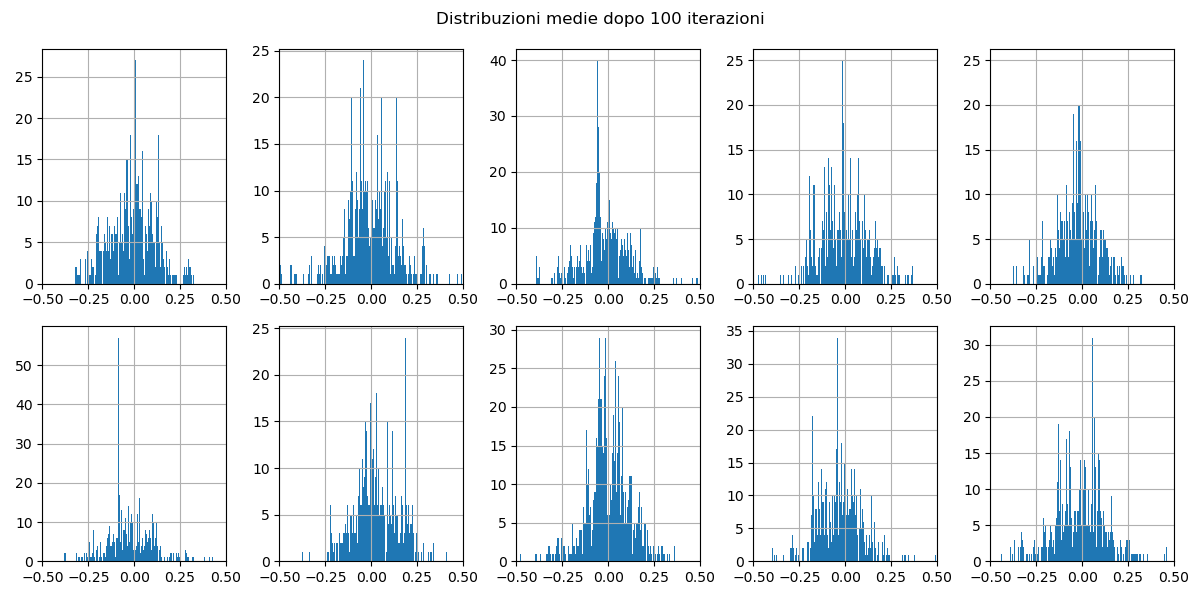

In [118]:
fig3,ax3 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='none',layout='tight')
fig3.suptitle("Distribuzioni medie dopo 100 iterazioni")
for i,a in enumerate(ax3.flatten()):
  a.hist(amus[i],bins=300)
  a.set_xlim((-0.50,0.5))
  a.grid()

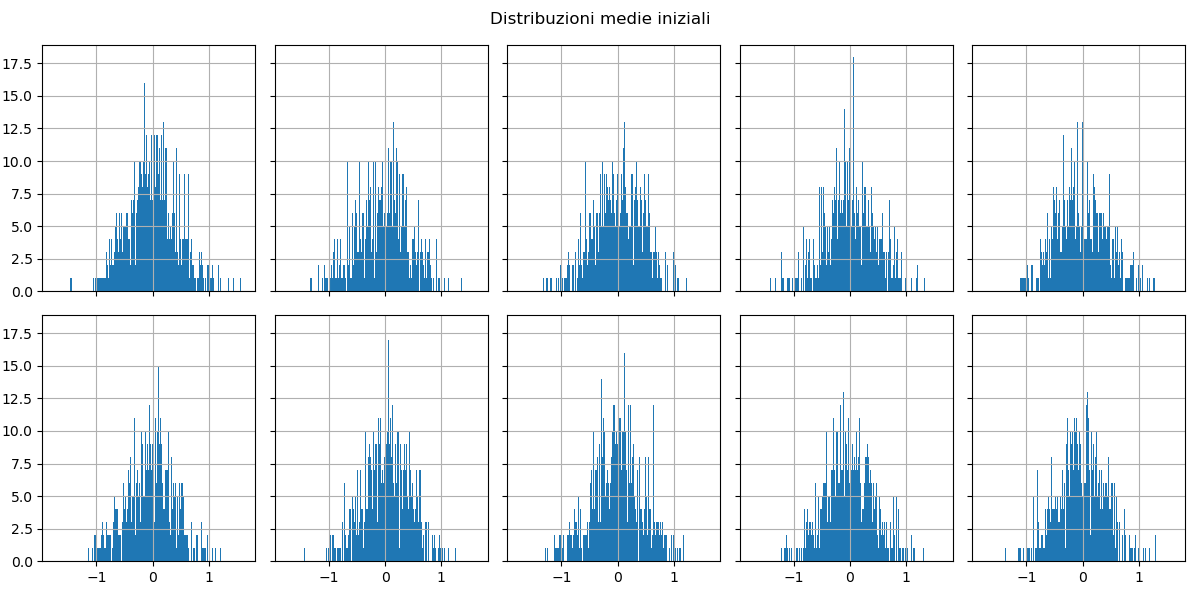

In [119]:
fig4,ax4 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',sharex='all',layout='tight')
fig4.suptitle("Distribuzioni medie iniziali")
for i,a in enumerate(ax4.flatten()):
  a.hist(muzeros[i],bins=300)
  #a.set_xlim((-0.50,0.5))
  a.grid()

In [120]:
fig1.savefig(outputdir+'finalsigmas.png')
fig2.savefig(outputdir+'initialsigmas.png')
fig3.savefig(outputdir+'finalmus.png')
fig4.savefig(outputdir+'initialmus.png')


In [121]:
plt.close('all')

In [137]:
datestr = (datetime.datetime.now()).strftime("%m_%d_%H_%M_")
np.save(outputdir+datestr+"10mus.npy", np.stack([np.array(muzeros),amus]) )
np.save(outputdir+datestr+"10sigma2s.npy", np.stack([np.array(sigma2zeros),asigma2s]))